In [1]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

function least_squares_solution(mat, y)
    inv(transpose(mat) * mat)*transpose(mat) * y
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [35]:
reconstructionsx = []
reconstructionsy = []
for max_order in [10, 20, 30, 40]
    print("Doing $max_order")
    discretization = 50
    zernike_samples = []
    ordering = []
    for n in range(0, max_order, step=1)
        for m in range(0, n, step=1)
            if (n-m)%2 == 0
                Zeven(ρ, ϕ) = R(n, m, ρ) * cos(m * ϕ)
                push!(zernike_samples, sample_across_unit_disk(Zeven, discretization)[3][:])
                push!(ordering, (n, m))
                if m !=0
                    Zodd(ρ, ϕ) = R(n, m, ρ) * sin(m * ϕ)
                    push!(zernike_samples, sample_across_unit_disk(Zodd, discretization)[3][:])
                    push!(ordering, (n, -m))
                end
            end
        end
    end
    Z = reduce(hcat, zernike_samples);
    σ1 = .1
    σ2 = 1
    amp = 1 # Used to make the small angle approximation work better.
    function gaussian(σ1, σ2)
        function func(ρ, ϕ)
            x = ρ*cos(ϕ)
            y = ρ*sin(ϕ)
            amp * exp(-x^2/σ1^2 + -y^2/σ2^2)
        end
    end
    xx, yy, zz = sample_across_unit_disk(gaussian(σ1, σ2), discretization)
    G = zz[:];
    coefficients = least_squares_solution(Z, G)
    reconstruction = zeros(discretization*discretization)
    for (i, zernike_sample) in enumerate(zernike_samples)
        reconstruction += coefficients[i] * zernike_sample
    end
    push!(reconstructionsx, reshape(reconstruction, (discretization, discretization))[:,Int64(discretization/2)][Int64(end/2):end])
    push!(reconstructionsy, reshape(reconstruction, (discretization, discretization))[Int64(discretization/2), :][Int64(end/2):end])
end

Doing 10Doing 20Doing 30Doing 40

LoadError: InterruptException:

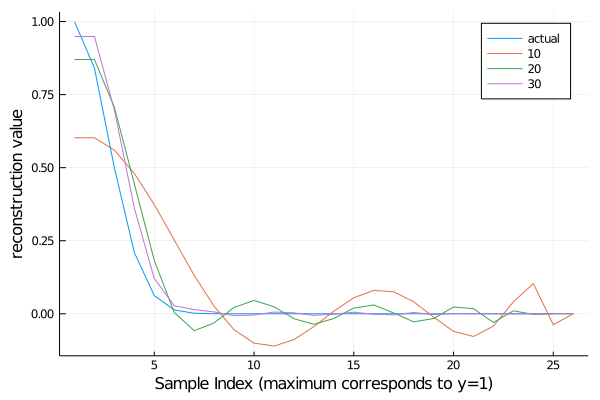

In [45]:
using Plots
gaussx = [[exp(-x ^2/σ1^2) for x in range(0, 1, length=Int64(discretization/2))]]
plot(vcat(gaussx,reconstructionsx), labels=["actual" "10" "20" "30"], xlabel="Sample Index (maximum corresponds to y=1)", ylabel="reconstruction value")

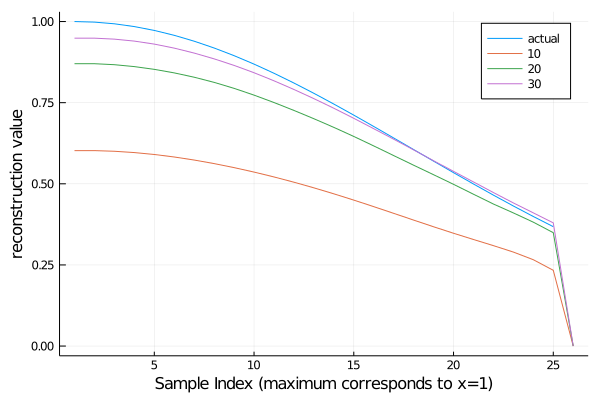

In [46]:
using Plots
gaussy = [[exp(-x ^2/σ2^2) for x in range(0, 1, length=Int64(discretization/2))]]
plot(vcat(gaussy,reconstructionsy), labels=["actual" "10" "20" "30"], xlabel="Sample Index (maximum corresponds to x=1)", ylabel="reconstruction value")